In [1]:
#Jenna Honeywell
#MSDS 422
#Assignment 4

In [ ]:
#Compete in the Kaggle.com House Prices: Advanced Regression Techniques competition.

#Investigate many variables. Employ at least two regression modeling methods: linear regression, stochastic gradient descent,
#ridge regression, lasso regression, and elastic net. Also employ random forests to the regression problem. Evaluate these 
#methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Submit at
#least two models to Kaggle.com for evaluation.

#Try alternative versions of random forests and gradient boosting. Select a best modeling method. Employ that method on
#the full data set, obtaining results that you can report to management.

In [2]:
import pandas as pd
import math
from math import sqrt
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport as pp
import random
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
import IPython 
from IPython.display import display
from scipy.stats import skew

%matplotlib inline

import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

pd.set_option('display.float_format', lambda x: '%3f' %x)


from sklearn.utils import resample
from sklearn.decomposition import PCA
from scipy import misc
from scipy import stats as st
from sklearn.model_selection import KFold, GridSearchCV

In [3]:
housing_train = pd.read_csv("housing_train.csv")
housing_test = pd.read_csv("housing_test.csv")

In [4]:
pp(housing_train, title = "Pandas Profiling Report")

In [5]:
housing_train.SalePrice.describe()

count     1460.000000
mean    180921.195890
std      79442.502883
min      34900.000000
25%     129975.000000
50%     163000.000000
75%     214000.000000
max     755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.8828757597682129


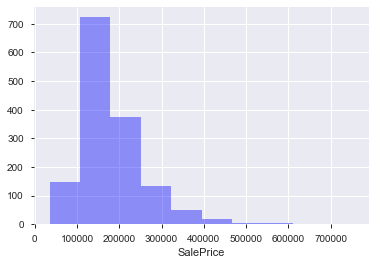

In [6]:
print("Skewness:", housing_train.SalePrice.skew())
sns.distplot(housing_train.SalePrice, bins = 10, kde = False, color='blue')
plt.show()
#The plot below shows a positive skew.  This data will have to be transformed to have a more normal distribution

Skewness: 0.12133506220520406


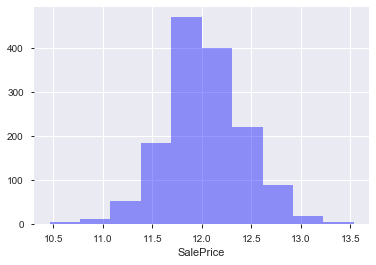

In [7]:
# Transforming the training data to have a more normal distribution
log_SalePrice = np.log(housing_train.SalePrice)
print("Skewness:", log_SalePrice.skew())
sns.distplot(log_SalePrice, bins = 10, kde = False, color='blue')
plt.show()

In [8]:
#Looking at correlation between target varibale (SalePrice) and features
corr_housing_train = housing_train.corr()
print(corr_housing_train['SalePrice'].sort_values(ascending=False)[:6], "\n")
print(corr_housing_train['SalePrice'].sort_values(ascending=False)[-6:])

SalePrice     1.000000
OverallQual   0.790982
GrLivArea     0.708624
GarageCars    0.640409
GarageArea    0.623431
TotalBsmtSF   0.613581
Name: SalePrice, dtype: float64 

LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


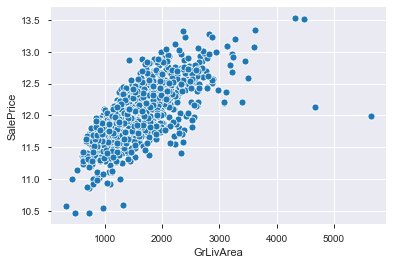

In [9]:
#Looking at the relationship between GrLivArea and SalePrice
sns.scatterplot(x=housing_train['GrLivArea'], y=log_SalePrice)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [10]:
# Removing outliers
housing_train = housing_train[housing_train['GrLivArea'] < 4000]

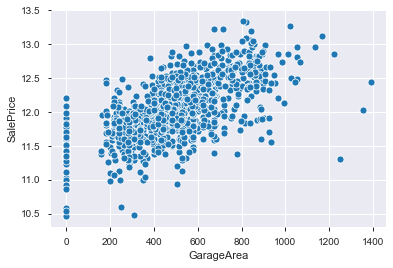

In [11]:
#Looking at the relationship between GarageArea and SalePrice
sns.scatterplot(x=housing_train['GarageArea'], y=log_SalePrice)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.show()

In [12]:
#Removing outliers
housing_train = housing_train[housing_train['GarageArea'] < 1200]

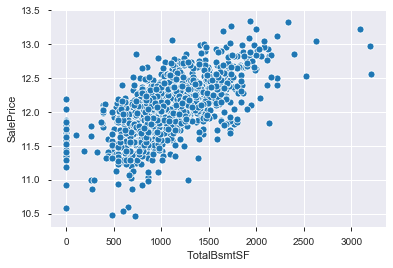

In [13]:
#Looking at the relationship between GarageArea and SalePrice
sns.scatterplot(x=housing_train['TotalBsmtSF'], y=log_SalePrice)
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')
plt.show()
#This looks fine, there are no obvious outliers to remove

In [14]:
#Taking a look at which columns contain 0/NaN data and seeing how many NaN values are in each column
nan_data = pd.DataFrame(housing_train.isnull().sum().sort_values(ascending=False)[:20])
nan_data.columns = ['NaN Count']
nan_data

,NaN Count
PoolQC,1447
MiscFeature,1399
Alley,1361
Fence,1172
FireplaceQu,689
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81
GarageFinish,81


In [15]:
#Deleting Id as it's an identifier column and not useful for determining sale price
#del housing_train['Id']

In [16]:
#Filling missing values where NaN values indicate No or None per the data description or where it makes sense and NaN
#likely indicates that the feature is not present
housing_train.loc[:, "MasVnrType"] = housing_train.loc[:, "MasVnrType"].fillna("No")
housing_train.loc[:, "MasVnrArea"] = housing_train.loc[:, "MasVnrArea"].fillna(0)
housing_train.loc[:, "BsmtQual"] = housing_train.loc[:, "BsmtQual"].fillna("No")
housing_train.loc[:, "BsmtCond"] = housing_train.loc[:, "BsmtCond"].fillna("No")
housing_train.loc[:, "BsmtExposure"] = housing_train.loc[:, "BsmtExposure"].fillna("No")
housing_train.loc[:, "BsmtFinType1"] = housing_train.loc[:, "BsmtFinType1"].fillna("No")
housing_train.loc[:, "BsmtFinType2"] = housing_train.loc[:, "BsmtFinType2"].fillna("No")
housing_train.loc[:, "FireplaceQu"] = housing_train.loc[:, "FireplaceQu"].fillna("No")
housing_train.loc[:, "GarageType"] = housing_train.loc[:, "GarageType"].fillna("No")
housing_train.loc[:, "GarageFinish"] = housing_train.loc[:, "GarageFinish"].fillna("No")
housing_train.loc[:, "GarageQual"] = housing_train.loc[:, "GarageQual"].fillna("No")
housing_train.loc[:, "GarageCond"] = housing_train.loc[:, "GarageCond"].fillna("No")
housing_train.loc[:, "GarageYrBlt"] = housing_train.loc[:, "GarageYrBlt"].fillna(0)
housing_train.loc[:, "LotFrontage"] = housing_train.loc[:, "LotFrontage"].fillna(0)
housing_train.loc[:, "PoolQC"] = housing_train.loc[:, "PoolQC"].fillna("No")
housing_train.loc[:, "MiscFeature"] = housing_train.loc[:, "MiscFeature"].fillna("No")
housing_train.loc[:, "Alley"] = housing_train.loc[:, "Alley"].fillna("No")
housing_train.loc[:, "Fence"] = housing_train.loc[:, "Fence"].fillna("No")

#Checking which columns still have missing data
print(housing_train.columns[housing_train.isnull().any()])

Index(['Electrical'], dtype='object')


In [17]:
electric = housing_train['Electrical']
#Per the count, electric is missing one value.  Since Na is not explained by the data description and the vast majority of 
#American homes have electricity, I'm assuming it was a fluke and am filling the NaN using bfill
housing_train['Electrical'].fillna(method="bfill", inplace=True)

#Checking which columns still have missing data
print(housing_train.columns[housing_train.isnull().any()])

Index([], dtype='object')


In [18]:
#nan_data_test = pd.DataFrame(housing_test.isnull().sum().sort_values(ascending=False)[:20])
#nan_data_test.columns = ['NaN Count']
#nan_data_test

In [19]:
# Differentiate and count numerical features (minus the target) and categorical features
cat_features = housing_train.select_dtypes(include = ["object"]).columns
num_features = housing_train.select_dtypes(exclude = ["object"]).columns
num_features = num_features.drop("SalePrice")
print("Numerical features : " + str(len(num_features)))
print("Categorical features : " + str(len(cat_features)))
housing_train_num = housing_train[num_features]
housing_train_cat = housing_train[cat_features]

Numerical features : 37
Categorical features : 43


In [20]:
housing_all = pd.concat((housing_train.loc[:,'MSSubClass':'SaleCondition'], housing_test.loc[:,'MSSubClass':'SaleCondition']))

In [21]:
housing_train.SalePrice = np.log1p(housing_train.SalePrice)
y = housing_train.SalePrice

In [22]:
num_features_all = housing_all.dtypes[housing_all.dtypes != "object"].index

skews = housing_train[num_features_all].apply(lambda x: skew(x.dropna())) #this line computes skewness
skews = skews[skews > 0.75]
skews = skews.index

housing_all[skews] = np.log1p(housing_all[skews])

In [23]:
housing_all = pd.get_dummies(housing_all)

In [24]:
housing_all = housing_all.fillna(housing_all.mean())

In [25]:
X_train = housing_all[:housing_train.shape[0]] #training data
X_test = housing_all[housing_train.shape[0]:] #testing data
y = housing_train.SalePrice #log transformed training sale prices

In [26]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring = scorer, cv = 5))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y, scoring = scorer, cv = 5))
    return(rmse)

In [27]:
##### Linear Regression #####
lr=LinearRegression()
lr.fit(X_train, y)
lr.score(X_train, y)

0.9492709599961657

In [28]:
lr_pred_log=(lr.predict(X_test))
lr_pred=np.exp(lr_pred_log)
display(lr_pred_log)
display(lr_pred)

df_lr_pred=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice':lr_pred})
df_lr_pred.to_csv('lr.csv', index=False)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

#Kaggle 5.15696

array([6.57812345, 6.78106728, 6.99361804, ..., 6.92220374, 6.4262659 ,
       7.13050301])

array([ 719.18846755,  881.00850221, 1089.65677308, ..., 1014.55334237,
        617.86247375, 1249.50531961])

RMSE on Training set : 0.13535911203734408


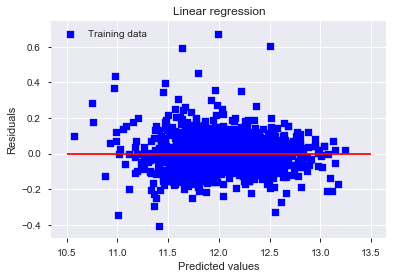

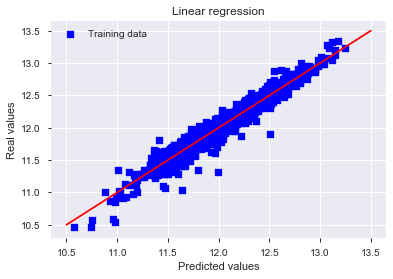

In [29]:
#Plot residuals
plt.scatter(y_train_pred, y_train_pred - y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

#Plot predictions
plt.scatter(y_train_pred, y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [30]:
##### Ridge Regression #####
ridge=Ridge(alpha=1, solver='cholesky')
ridge.fit(X_train, y)
ridge.score(X_train, y)

0.9480392589204634

In [31]:
ridge_pred_log=(ridge.predict(X_test))
ridge_pred=np.exp(ridge_pred_log)
display(ridge_pred_log)
display(ridge_pred)

df_ridge_pred=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice':ridge_pred})
df_ridge_pred.to_csv('ridge.csv', index=False)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

#Kaggle 0.12316

array([11.73080114, 11.94758736, 12.14486138, ..., 12.06827025,
       11.72961567, 12.28442151])

array([124343.24649179, 154444.07951984, 188124.89874784, ...,
       174254.16917179, 124195.9292384 , 216299.97728884])

Ridge RMSE on Training set : 0.11677716788294826


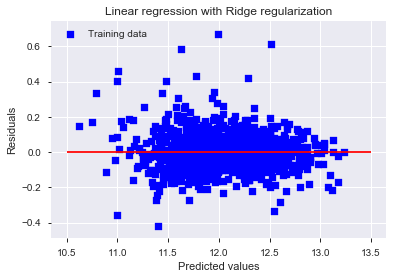

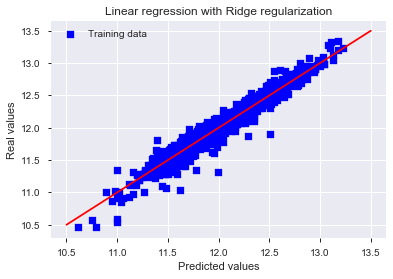

Ridge picked 300 features and eliminated the other 1 features


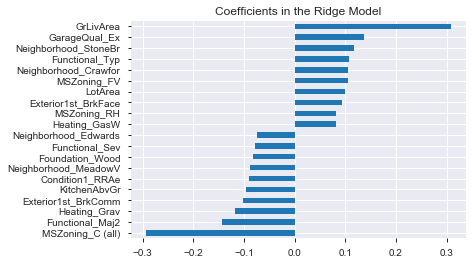

In [32]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()


#Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [33]:
##### Lasso Regression #####
lasso=Lasso(alpha=0.1)
lasso.fit(X_train, y)
lasso.score(X_train, y)

0.7735925785175224

In [34]:
lasso_pred_log=(lasso.predict(X_test))
lasso_pred=np.exp(lasso_pred_log)
display(lasso_pred_log)
display(lasso_pred)

df_lasso_pred=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice':lasso_pred})
df_lasso_pred.to_csv('lasso.csv', index=False)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

#Kaggle 0.20611

array([11.89608557, 11.89869026, 12.24078704, ..., 12.20614216,
       11.71000485, 12.33452233])

array([146691.28669782, 147073.87070965, 207064.79415161, ...,
       200013.90319151, 121784.07155646, 227412.84221938])

Lasso RMSE on Training set : 0.18940477200791433


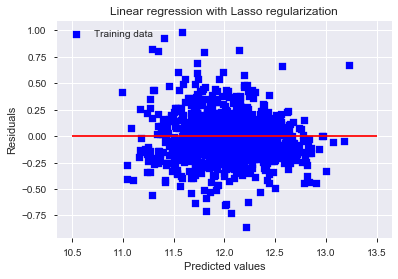

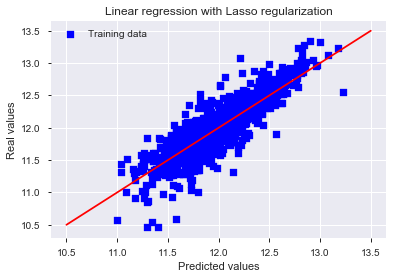

Lasso picked 8 features and eliminated the other 293 features


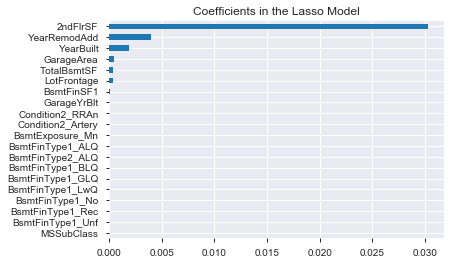

In [35]:
# Plot residuals
plt.scatter(y_train_las, y_train_las - y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [36]:
##### Elastic Net Regression #####
elastic_net=ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y)
elastic_net.score(X_train, y)

0.8224136771599845

In [37]:
en_pred_log=(elastic_net.predict(X_test))
en_pred=np.exp(en_pred_log)
display(en_pred_log)
display(en_pred)

df_en_pred=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice': en_pred})
df_en_pred.to_csv('en.csv', index=False)

print("ElasticNet RMSE on Training set :", rmse_cv_train(elastic_net).mean())
y_train_ela = elastic_net.predict(X_train)
y_test_ela = elastic_net.predict(X_test)

#Kaggle 0.18258

array([11.83785388, 11.92199732, 12.16257956, ..., 12.16336748,
       11.72459994, 12.37733346])

array([138393.15673274, 150541.98870882, 191487.83518756, ...,
       191638.77153491, 123574.55584893, 237360.04784692])

ElasticNet RMSE on Training set : 0.1681668932944042


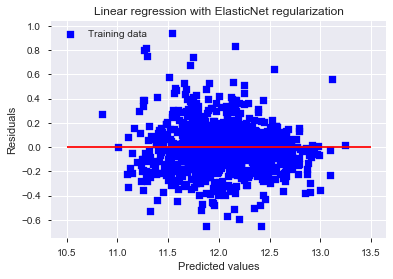

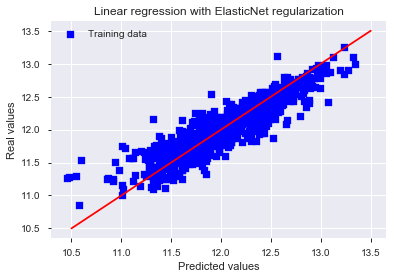

ElasticNet picked 10 features and eliminated the other 291 features


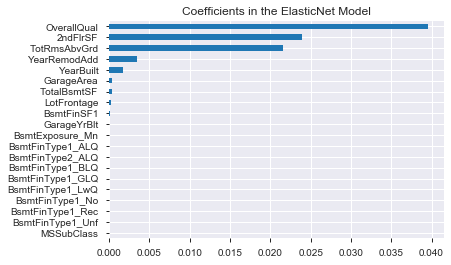

In [38]:
# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elastic_net.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier 
from sklearn.svm import SVC

In [40]:
#new, unedited datasets 
housing_train = pd.read_csv("housing_train.csv")
housing_test = pd.read_csv("housing_test.csv")

In [41]:
housing_all = pd.concat((housing_train.loc[:,'MSSubClass':'SaleCondition'], housing_test.loc[:,'MSSubClass':'SaleCondition']))

In [42]:
housing_all = housing_all.fillna(housing_all.mean())

In [43]:
housing_all = pd.get_dummies(housing_all)

In [44]:
#Decision Tree
X_train = housing_all[:housing_train.shape[0]] #training data
X_test = housing_all[housing_train.shape[0]:] #testing data
y = housing_train.SalePrice #training sale prices

In [45]:
dt = DecisionTreeRegressor(max_depth=10, max_features = 'log2', random_state=42)
dt.fit(X_train,y)
y_dt_pred=dt.predict(X_test)
y_dt_pred_train=dt.predict(X_train)

print(f"Train score : {dt.score(X_train,y)}")
print("Decision Tree RMSE on Training set :", rmse_cv_train(dt).mean())

df_dt=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice': y_dt_pred})
df_dt.to_csv('dt.csv', index=False)

#Kaggle 0.23737

Train score : 0.9240512403377777
Decision Tree RMSE on Training set : 49763.0937463037


In [46]:
#Feature Importance 
col_sorted_by_importance=dt.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'Features':X_train.columns[col_sorted_by_importance],
    'Importance':dt.feature_importances_[col_sorted_by_importance]
})
feat_imp.sort_values(by='Importance',ascending=False).head(10)

,Features,Importance
287,TotalBsmtSF,0.448231
286,2ndFlrSF,0.185945
285,HeatingQC_Ex,0.040058
284,YearBuilt,0.035291
283,GrLivArea,0.035199
282,GarageType_Attchd,0.021377
281,GarageCars,0.019068
280,GarageArea,0.017369
279,BsmtUnfSF,0.015407
278,LandContour_Bnk,0.009483


In [47]:
#Decision Tree with only top five important features 
housing_all_top_feat = housing_all[['TotalBsmtSF', '2ndFlrSF', 'HeatingQC_Ex', 'YearBuilt', 'GrLivArea']]
X_train_trim = housing_all_top_feat[:housing_train.shape[0]] #training data
X_test_trim = housing_all_top_feat[housing_train.shape[0]:] #testing data
y = housing_train.SalePrice #training sale prices

In [48]:
dt2 = DecisionTreeRegressor(max_depth=10, max_features = 'log2', random_state=42)
dt2.fit(X_train_trim,y)
y_dt2_pred=dt2.predict(X_test_trim)
y_dt2_pred_train=dt2.predict(X_train_trim)

print(f"Train score : {dt2.score(X_train_trim,y)}")
print("Decision Tree Trimmed RMSE on Training set :", rmse_cv_train(dt2).mean())

df_dt2=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice': y_dt2_pred})
df_dt2.to_csv('dt2.csv', index=False)

#Kaggle 0.22003

Train score : 0.950294281333673
Decision Tree Trimmed RMSE on Training set : 49763.0937463037


In [49]:
#Random Forest
rfr=RandomForestRegressor(max_depth=15, max_features=100, bootstrap=True, random_state=42)
rfr.fit(X_train,y)
y_pred=rfr.predict(X_test)
y_pred_train=rfr.predict(X_train)

print(f"Train score : {rfr.score(X_train,y)}")

print("Random Forest RMSE on Training set :", rmse_cv_train(rfr).mean())
y_train_rfr = rfr.predict(X_train)
y_test_rfr = rfr.predict(X_test)

df_rfr=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice': y_pred})
df_rfr.to_csv('rfr.csv', index=False)

#Kaggle: max_depth=10; max_features=log2 = .18165; .8998 on training set
#Kaggle: max_depth=10; max_features=log2 = .17865; .933 on training set
#Kaggle: max_depth=15; max_features=log2 = .16734; .969 on training set
#Kaggle: max_depth=20; max_features=log2 = .16549; .975 on training set
#Kaggle: max_depth=10; max_features=100 = .14893; .974 on training set
#Kaggle: max_depth=15; max_features=75 = .14822; .980 on training set
#Kaggle: max_depth=15; max_features=100 = .14806; .981 on training set

Train score : 0.9811584431085787
Random Forest RMSE on Training set : 28770.616853593325


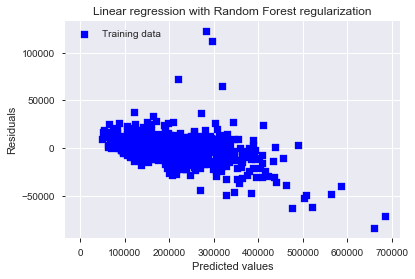

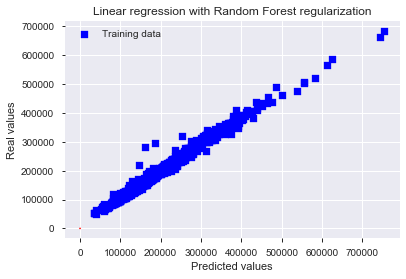

In [50]:
plt.scatter(y_train_rfr, y_train_rfr - y, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Random Forest regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y, y_train_rfr, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Random Forest regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [51]:
#Feature Importance 
col_sorted_by_importance=rfr.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'Features':X_train.columns[col_sorted_by_importance],
    'Importance':rfr.feature_importances_[col_sorted_by_importance]
})
feat_imp.sort_values(by='Importance',ascending=False).head(10)

,Features,Importance
287,OverallQual,0.271127
286,GrLivArea,0.117824
285,GarageCars,0.110124
284,ExterQual_TA,0.065528
283,TotalBsmtSF,0.043406
282,GarageArea,0.034754
281,2ndFlrSF,0.031343
280,1stFlrSF,0.029624
279,YearBuilt,0.029451
278,BsmtQual_Ex,0.021864


In [52]:
#Random Forest with only top five important features 
housing_all_top_feats = housing_all[['OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual_TA', 'TotalBsmtSF']]
X_train2_trim = housing_all_top_feats[:housing_train.shape[0]] #training data
X_test2_trim = housing_all_top_feats[housing_train.shape[0]:] #testing data
y2 = housing_train.SalePrice #training sale prices

In [53]:
#Random Forest 2 
rfr2=RandomForestRegressor(max_depth=15, max_features=5, bootstrap=True, random_state=42)
rfr2.fit(X_train2_trim,y2)
y_pred2=rfr2.predict(X_test2_trim)
y_pred2_train=rfr2.predict(X_train2_trim)

print(f"Train score : {rfr2.score(X_train2_trim,y2)}")

print("Random Forest RMSE on Training set :", rmse_cv_train(rfr2).mean())
y_train2_rfr = rfr2.predict(X_train2_trim)
y_test2_rfr = rfr2.predict(X_test2_trim)

df_rfr2=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice': y_pred2})
df_rfr2.to_csv('rfr2.csv', index=False)

#Kaggle 0.17695

Train score : 0.9702628393348477
Random Forest RMSE on Training set : 34493.905981593394


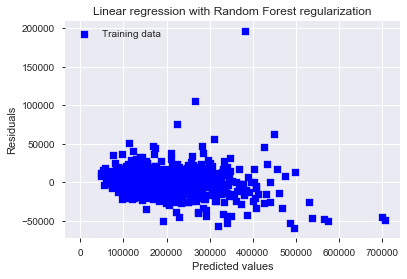

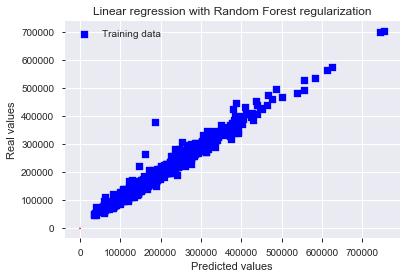

In [54]:
plt.scatter(y_train2_rfr, y_train2_rfr - y2, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Random Forest regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y2, y_train2_rfr, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression with Random Forest regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [56]:
#Gradient Boosting 
from xgboost import XGBRegressor
xgb=XGBRegressor(learning_rate=0.1)
xgb.fit(X_train,y)
xgb_pred=(xgb.predict(X_test))

print(f"Train score : {xgb.score(X_train,y)}")
print("Gradient Boosting RMSE on Training set :", rmse_cv_train(xgb).mean())

df_xgb=pd.DataFrame({'Id': housing_test['Id'], 'SalePrice': xgb_pred})
df_xgb.to_csv('xgb.csv', index=False)

#Kaggle 0.14028

Train score : 0.9942311838506279
Gradient Boosting RMSE on Training set : 28086.323535068368


In [57]:
#Feature Importance 
col_sorted_by_importance=xgb.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'Features':X_train.columns[col_sorted_by_importance],
    'Importance':xgb.feature_importances_[col_sorted_by_importance]
})
feat_imp.sort_values(by='Importance',ascending=False).head(10)

,Features,Importance
287,OverallQual,0.324653
286,BsmtQual_Ex,0.112404
285,GarageCars,0.074384
284,GrLivArea,0.034135
283,KitchenQual_Ex,0.033696
282,CentralAir_N,0.029436
281,KitchenAbvGr,0.025300
280,KitchenQual_TA,0.020001
279,GarageQual_TA,0.015140
278,KitchenQual_Gd,0.014626
